# Occupazione della stanza

Per prima cosa iniziamo a recuperare il dataset

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

X = pd.read_csv('./data/datatraining.txt')

Quindi andiamo a creare una nuova feature che indica il giorno della settimana (facciamo un mapping con i nomi dei giorni in italiano)

In [3]:
X['date'] = pd.to_datetime(X['date'], format='mixed')
X['weekday'] = X['date'].dt.day_name()
mapping = {
    'Monday': 'Lunedì', 'Tuesday': 'Martedì', 'Wednesday': 'Mercoledì',
    'Thursday': 'Giovedì', 'Friday': 'Venerdì', 'Saturday': 'Sabato', 'Sunday': 'Domenica'
}
order = ['Lunedì', 'Martedì', 'Mercoledì', 'Giovedì', 'Venerdì', 'Sabato', 'Domenica']
X['weekday'] = X['weekday'].map(mapping)

Visualizziamo il numero di presenze per ogni giorno della settimana

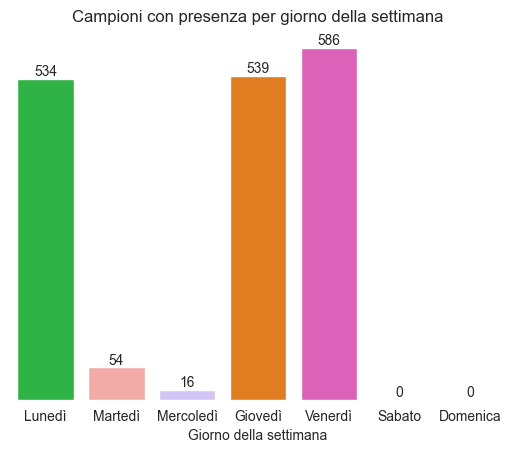

In [4]:
counts = X.groupby('weekday')['Occupancy'].sum()

palette = sns.color_palette("pastel", n_colors=len(counts))
for i, count in enumerate(counts.values):
    if count > 500:
        palette[i] = sns.color_palette("bright")[i]
sns.set_style('white')

barplot = sns.barplot(x=counts.index, y=counts.values, order=order, hue=counts.index, palette=palette)
plt.xlabel('Giorno della settimana')
plt.title('Campioni con presenza per giorno della settimana')

barplot.set(yticklabels=[])

for container in barplot.containers:
    barplot.bar_label(container, fmt='%d', label_type='edge')

for spine in barplot.spines.values():
    spine.set_visible(False)

plt.savefig("./plots/campioni_con_presenza_per_giorno.png", transparent=True)

plt.show()

Dal grafico osserviamo che **la presenza nella stanza non è distribuita in modo uniforme** durante la settimana. I **valori più alti** si registrano **lunedì, giovedì e venerdì**, con un numero di campioni molto simile e un picco leggermente superiore il venerdì. Questo indica che la stanza viene utilizzata soprattutto in questi tre giorni.

Al contrario, **martedì e mercoledì** mostrano una **presenza molto ridotta**. Infine, **sabato e domenica** presentano **valori pari a zero**, il che suggerisce che nel weekend la stanza rimane sempre vuota.

Nel complesso il grafico evidenzia un chiaro pattern: l’occupazione è concentrata in pochi giorni specifici, mentre nel resto della settimana la stanza è quasi sempre vuota.

Ora proviamo a visualizzare, utilizzando degli small multiples, l'andamento temporale di ogni feature, rispetto al fatto che ci sia o meno qualcuno nella stanza (evidenziando in rosso quando qualcuno è presente nella stanza) e dividendo i giorni con delle barre verticali.

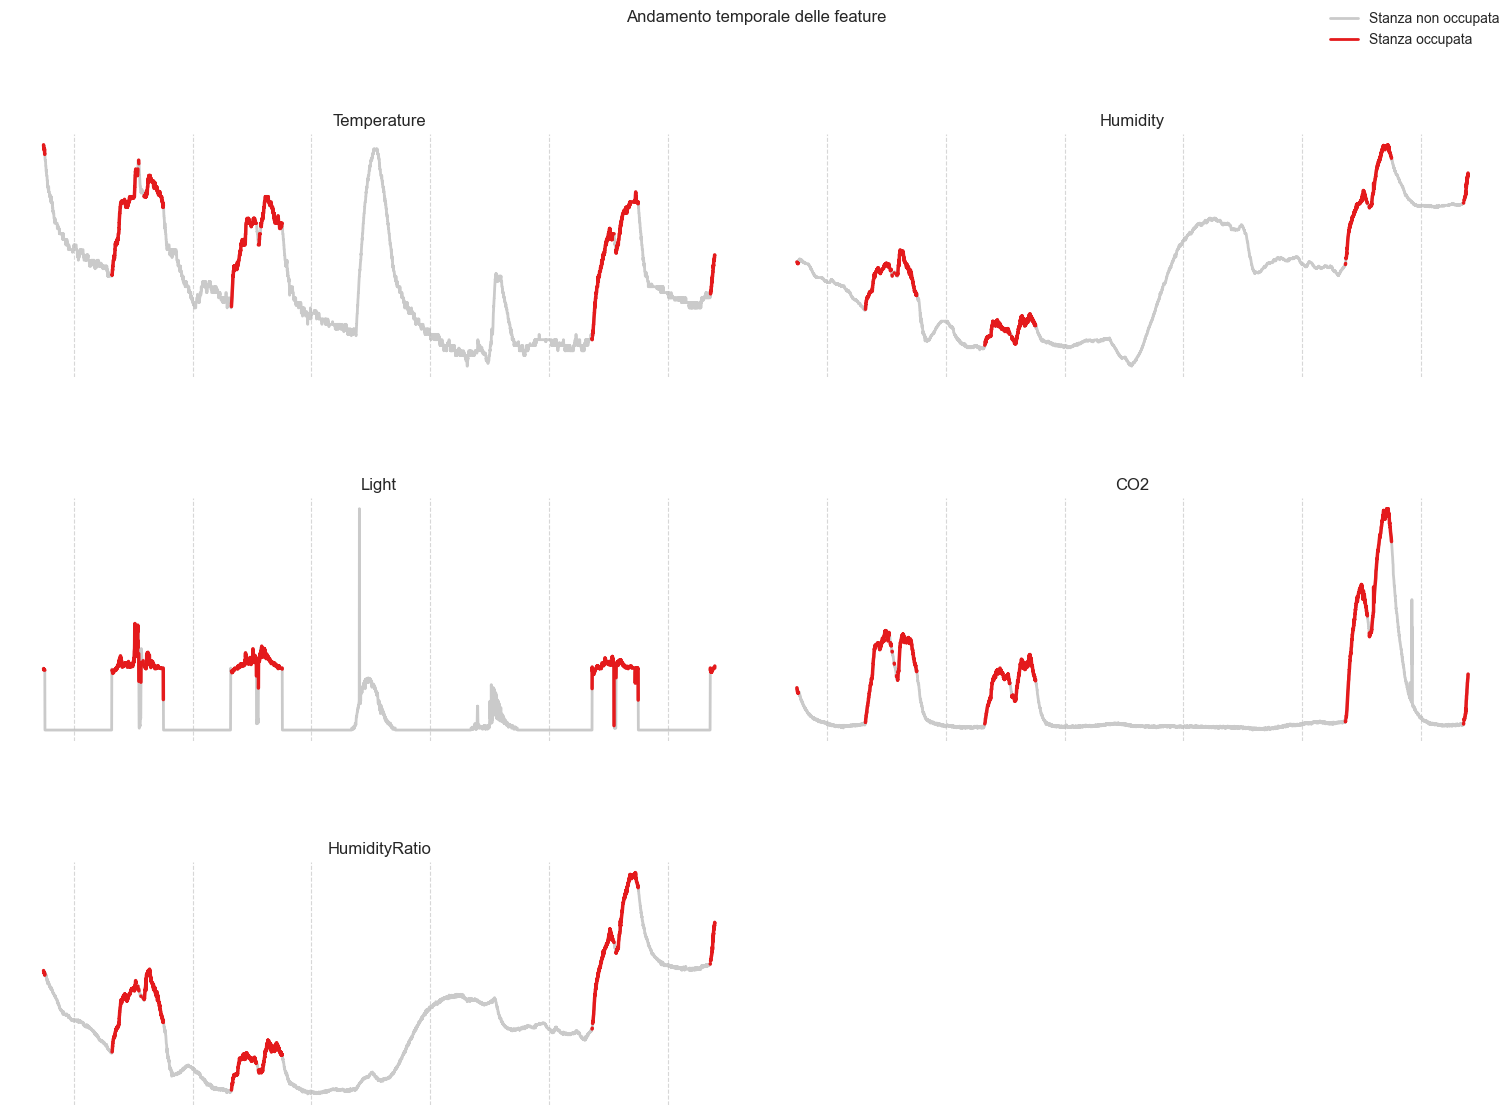

In [47]:
# definiamo i colori per il grafico
grey = '#bdbdbd'
red = '#e41a1c'

# selezioniamo solo le feature numeriche ed escludiamo l'Occupancy, che mostriamo con il colore "red"
features = [c for c in X.columns if c not in ['date', 'weekday', 'Occupancy', 'Hour']]

# definiamo la griglia che conterrà gli small multiples, indicando dimensioni e padding
n = len(features)
fig, axes = plt.subplots(3, 2, figsize=(15, 10), constrained_layout=True)
fig.set_constrained_layout_pads(hspace=0.3)
axes = axes.flatten()

# aggiungiamo agli assi di tutti gli small multiple il rispettivo grafico
for ax, feat in zip(axes, features):
    sub = X[['date', 'Occupancy', feat]].sort_values('date').dropna(subset=['date', feat])

    # disegniamo il grafico completo in grigio
    ax.plot(sub['date'], sub[feat], color=grey, alpha=0.8, linewidth=2)

    # costruiamo una maschera binaria per trovare i "blocchi" di grafico dove Occupancy è uguale ad 1
    mask = sub['Occupancy'] == 1

    # ogni volta che la maschera cambia, creiamo un nuovo gruppo
    # (facciamo uno shift in modo da confrontare, utilizzando NEQ,
    # ogni campione con il precedente, così da capire dove inizia una sere
    # di valori con Occupancy 1 o 0, poi, utilizzando cumsum, a ogni sequenza
    # di valori con Occupancy uguale, viene "assegnato" un numero diverso,
    # in modo da poter ottenere dei gruppi su "sub", utilizzando groupby)
    groups = mask.ne(mask.shift(fill_value=False)).cumsum()
    for _, grp in sub.groupby(groups):
        #Controlliamo se il gruppo ha valori con Occupancy ad 1 (ci basta guardare il primo campione)
        if grp['Occupancy'].iloc[0] == 1:
            #In tal caso disegniamo un grafico rosso sopra a quello grigio
            ax.plot(grp['date'], grp[feat], color=red, alpha=1.0, linewidth=2.5)

    # disegniamo delle righe verticali tratteggiate a mezzanotte
    days = pd.to_datetime(sub['date'].dt.normalize().unique())
    y_min, y_max = ax.get_ylim()
    for day in days:
        t = day
        if sub['date'].iloc[0] <= t <= sub['date'].iloc[-1]:
            ax.axvline(t, color=grey, linestyle='--', linewidth=0.8, alpha=0.6)

    ax.set_title(feat)

    # rimuoviamo bordi e griglie per uno stile minimale
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

# eliminiamo gli assi non necessari
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])


# inseriamo la legenda
handle0 = mlines.Line2D([], [], color=grey, label='Stanza non occupata', linewidth=2, alpha=0.8)
handle1 = mlines.Line2D([], [], color=red, label='Stanza occupata', linewidth=2)
fig.legend(handles=[handle0, handle1], loc='upper right', frameon=False)
fig.suptitle('Andamento temporale delle feature', y=1.1)
plt.savefig("./plots/andamento_temporale_features.png", bbox_inches='tight',  transparent=True)
plt.show()

Nei grafici seguenti analizziamo l’**andamento temporale** di ciascuna feature, mettendo in evidenza i periodi in cui la stanza risulta occupata. Ogni variabile mostra un comportamento specifico, che risulta ben visibile grazie alla separazione in small multiples.

**Temperature**:
La temperatura tende a essere **più elevata** o comunque mostra picchi più pronunciati **quando la stanza è occupata**. I segmenti rossi coincidono spesso con fasi di aumento o stabilizzazione su valori più alti, suggerendo che la presenza umana (o l’accensione di dispositivi) contribuisce a un innalzamento termico.

**Humidity**:
L’umidità mostra **oscillazioni** interessanti: nelle zone rosse, la curva è generalmente più alta o più dinamica. Questo è coerente con l’idea che la presenza delle persone aumenti la quantità di vapore acqueo nell’aria (respirazione, movimento), generando picchi più marcati rispetto ai periodi di non occupazione.

**Light**:
La luce presenta **pattern molto netti**: quando la stanza è occupata, la linea rossa mostra livelli della luce significativamente più alti, compatibili con l’accensione delle lampade. Nei periodi in cui nessuno è presente (linea grigia), la luce rimane vicina allo zero o comunque molto più bassa.

**CO₂**:
Il CO₂ è **una delle feature più indicative**: nei periodi di occupazione i valori crescono in modo deciso e rapido, raggiungendo picchi molto più alti rispetto a quelli osservati quando la stanza è vuota. Questo è perfettamente **coerente con l’attività respiratoria** delle persone, che aumenta la concentrazione di anidride carbonica nell’ambiente.

**Humidity Ratio**:
Anche qui si osservano aumenti significativi nei periodi rossi. L’humidity ratio, che **combina temperatura e umidità**, segue un andamento simile a queste due variabili e risulta un **buon indicatore della presenza**, mostrando variazioni robuste quando qualcuno si trova nella stanza.


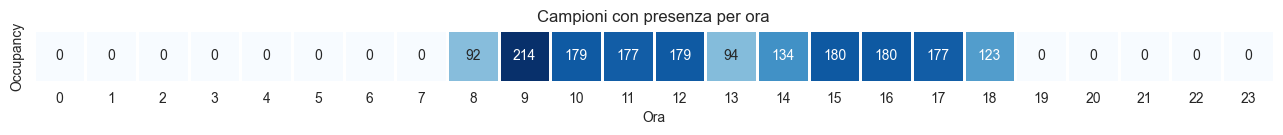

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

X["Hour"] = pd.to_datetime(X["date"]).dt.round("h").dt.hour


occupancy_by_hour = X[["Hour", "Occupancy"]]

grouped_by_hour = occupancy_by_hour.groupby("Hour")

grouped_by_hour.sum()

hourly_occupation_samples = grouped_by_hour.sum()


plt.figure(figsize=(16, 2))
sns.heatmap(
    hourly_occupation_samples.T,
    annot=True,
    cmap="Blues",
    square=True,
    cbar=False,
    linewidths=1,
    linecolor="white",
    fmt="d"
)

plt.title("Campioni con presenza per ora")
plt.xlabel("Ora")
plt.savefig("./plots/heatmap_campioni_per_ora.png", transparent=True)
plt.show()


Proviamo a rappresentare, usando dei box plot, la distribuzione delle feature rispetto al fatto che il campione sia contrassegnato come occupato o meno

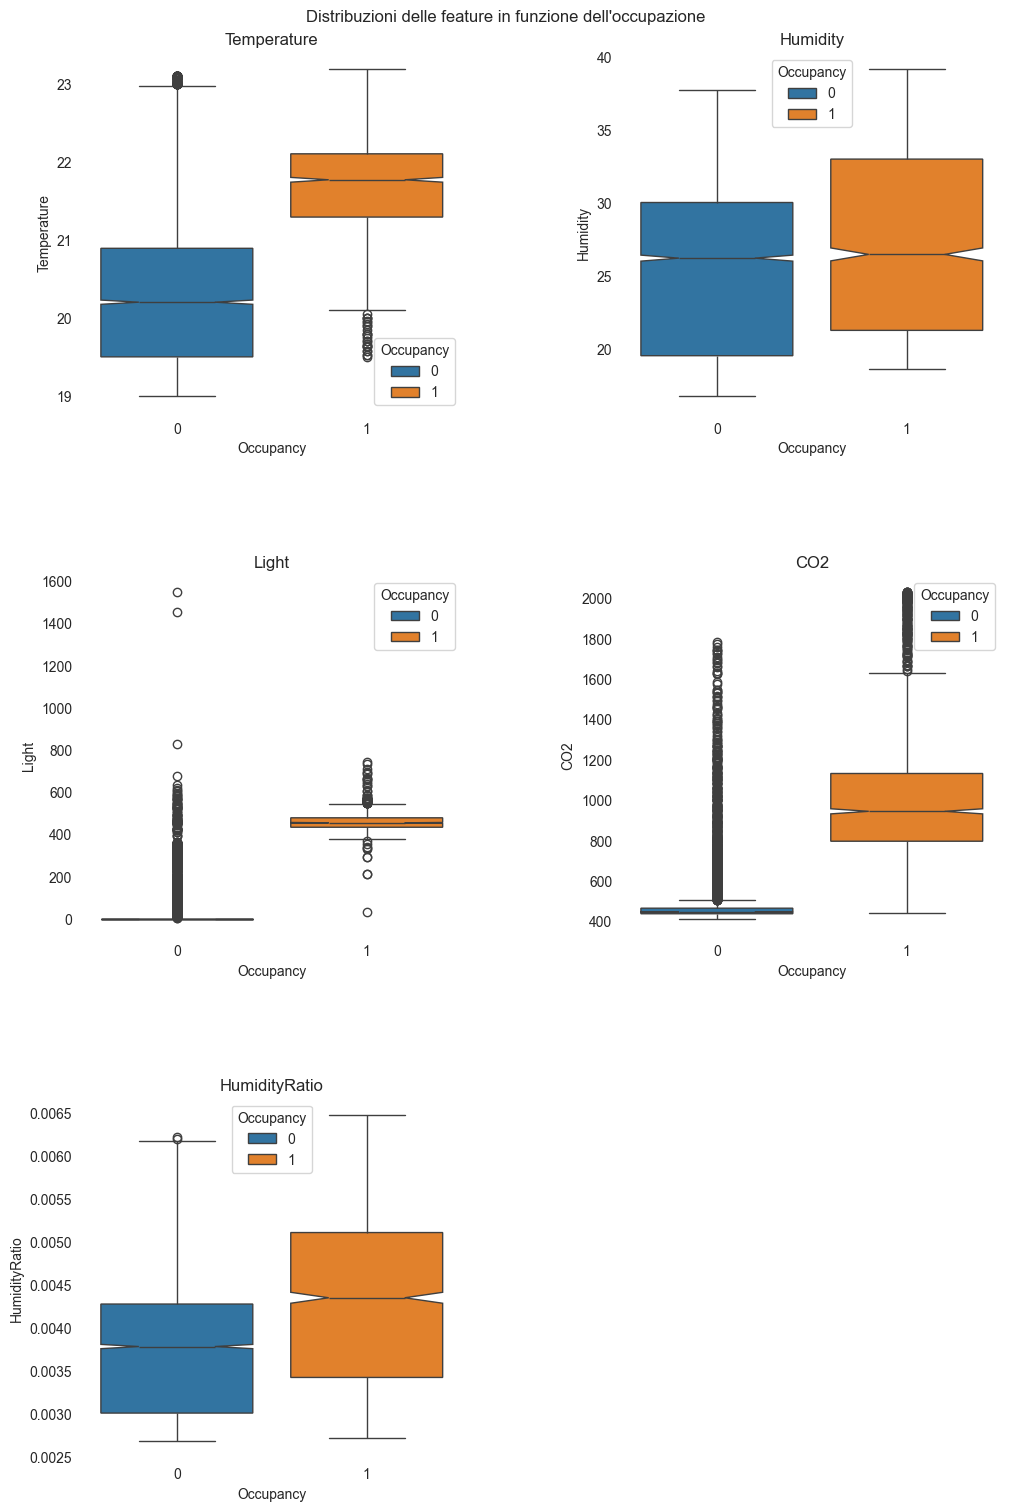

In [15]:
occupancy_by_light = X[["Light", "Occupancy"]]

features = X.columns.tolist()

features.remove('Occupancy')
features.remove('date')
features.remove('weekday')

fig, axes = plt.subplots(3, 2, constrained_layout=True, figsize=(10, 15))
fig.set_constrained_layout_pads(hspace=0.2, wspace=0.2)
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    sns.boxplot(
        data=X,
        x="Occupancy",
        y=feat,
        hue="Occupancy",
        palette="tab10",
        notch=True,
        ax=ax,
    )
    ax.set_title(feat)

    for spine in ax.spines.values():
        spine.set_visible(False)


for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Distribuzioni delle feature in funzione dell\'occupazione')

plt.savefig("./plots/box_plots.png")

plt.show()

Essendo che i notch dei box plot, relativi alla feature **"Humidity"** con *Occupancy=0* e *Occupancy=1* _si incontrano_, anche facendo un **test d'ipotesi**, mettendo come ipotesi nulla che le due distribuzioni siano uguali, **non possiamo confutare l'ipotesi nulla** (in sostanza, i due gruppi potrebbero essere campionamenti della stessa distribuzione).
Questa feature pertanto, sarà probabilmente **poco importante ai fini della classificazione**.

Nel caso della **temperatura**, i notch dei box plot sono _molto separati_, quindi avrà un'**importanza maggiore** ai fini della classificazione.
Lo stesso vale per la **luce** e per la **CO2**, in modo ancora più marcato, soprattutto per la **luce**.

Per l'**Humidity Ratio**, i due box plot _sono simili_, anche se i notch _non si incontrano_ quindi possiamo comunque dire che le distribuzioni possano essere abbastanza simili.
Probabilmente, anche questo parametro **non avrà molta importanza** all'interno della nostra **Random Forest**.
